# Session 8 homework

Download dataset

In [ ]:
!wget https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip

# Data preparation:
* Create a train and validation folders
* In each folder, create cats and dogs folders
* Move the first 10,000 images to the train folder (from 0 to 9999) for boths cats and dogs - and put them in respective folders
* Move the remaining 2,500 images to the validation folder (from 10000 to 12499)

In [ ]:
# unzip the downloaded dataset
import zipfile
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import os

#create folders
os.makedirs('train/dogs')
os.makedirs('train/cats')
os.makedirs('val/dogs')
os.makedirs('val/cats')

In [ ]:
# move the images
for i in range(0, 10000):
    os.rename(f'train/dog.{i}.jpg', f'train/dogs/dog.{i}.jpg')
    os.rename(f'train/cat.{i}.jpg', f'train/cats/cat.{i}.jpg')

for i in range(10000, 12500):
    os.rename(f'train/dog.{i}.jpg', f'val/dogs/dog.{i}.jpg')
    os.rename(f'train/cat.{i}.jpg', f'val/cats/cat.{i}.jpg')

## Model

For this homework we will use Convolutional Neural Network (CNN. Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

* The shape for input should be `(150, 150, 3)`
* Next, create a covolutional layer (`Conv2D`):
    * Use 32 filters
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation
* Reduce the size of the feature map with max pooling (`MaxPooling2D`)
    * Set the pooling size to (2, 2)
* Turn the multi-dimensional result into vectors using a `Flatten` layer
* Next, add a `Dense` layer with 64 neurons and `'relu'` activation
* Finally, create the `Dense` layer with 1 neuron - this will be the output

As optimizer use `SGD` with the following parameters:

* `SGD(lr=0.002, momentum=0.8)`

For clarification about kernel size and max pooling, check Week #11 Office Hours.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten


In [2]:
def make_model():
    # Model
    inputs = keras.Input(shape=(150, 150, 3))
    conv = keras.layers.Conv2D(32, 3, activation='relu')(inputs)
    pool = keras.layers.MaxPooling2D(pool_size=(2,2))(conv)
    vector = keras.layers.Flatten()(pool)
    dense = keras.layers.Dense(64, activation='relu')(vector)
    output = keras.layers.Dense(1, activation='sigmoid')(dense)
    model = keras.Model(inputs, output)

    # Optimizer. This is a single output problem, so BinaryCrossentropy seems better
    optimizer = keras.optimizers.SGD(learning_rate=0.002, momentum=0.8)
    loss = keras.losses.BinaryCrossentropy(from_logits=False)

    # Model compiling
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [ ]:
'''
def make_model_2_make_modeler():
    model = keras.models.Sequential()
    model.add(Conv2D(32, 3, activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer. This is a single output problem, so BinaryCrossentropy seems better
    optimizer = keras.optimizers.SGD(learning_rate=0.002, momentum=0.8)
    loss = keras.losses.BinaryCrossentropy(from_logits=False)

    # Model compiling
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model
'''

# Question 1
Since we have a binary classification problem, what is the best loss function for us?

## Question 1 solution

It looks like `BinaryCrossentropy` is the better choice, because we're dealing with a binary classification problem and this loss function is specific for it.

# Question 2
What's the total number of parameters of the model? You can use the summary method for that.

In [3]:
model = make_model()
#model = make_model_2_the_return()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                11214912  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 11,215,873
Trainable params: 11,215,873
Non-trainable params: 0
_________________________________________________

2021-11-22 12:25:03.238457: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Question 2 solution

Holy crap `11,215,873` parameters lol, most of them by the dense layer.

# Generators and Training

For the next two questions, create a data generator:

    ImageDataGenerator(rescale=1./255)

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/val directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use batch_size=20
* Use `shuffle=True` for both training and validaition


For training use `.fit()` with the following params:

    model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=50
    )

In [5]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# single generator because why not
gen = ImageDataGenerator(rescale=1./255)
train_ds = gen.flow_from_directory(
    './train',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary'
    )
val_ds = gen.flow_from_directory(
    './val',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary'
    )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
# training
history = model.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_ds,
    validation_steps=50
)

2021-11-22 12:25:21.270136: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
100/100 [==============================] - 13s 128ms/step - loss: 0.6955 - accuracy: 0.5185 - val_loss: 0.6900 - val_accuracy: 0.5540
Epoch 2/10
100/100 [==============================] - 12s 121ms/step - loss: 0.6905 - accuracy: 0.5265 - val_loss: 0.6846 - val_accuracy: 0.5530
Epoch 3/10
100/100 [==============================] - 12s 124ms/step - loss: 0.6872 - accuracy: 0.5375 - val_loss: 0.6828 - val_accuracy: 0.5760
Epoch 4/10
100/100 [==============================] - 12s 125ms/step - loss: 0.6749 - accuracy: 0.5830 - val_loss: 0.6835 - val_accuracy: 0.5580
Epoch 5/10
100/100 [==============================] - 12s 118ms/step - loss: 0.6721 - accuracy: 0.5830 - val_loss: 0.6702 - val_accuracy: 0.5900
Epoch 6/10
100/100 [==============================] - 12s 124ms/step - loss: 0.6727 - accuracy: 0.5830 - val_loss: 0.6754 - val_accuracy: 0.5610
Epoch 7/10
100/100 [==============================] - 13s 133ms/step - loss: 0.6614 - accuracy: 0.6020 - val_loss: 0.6513 - val_ac

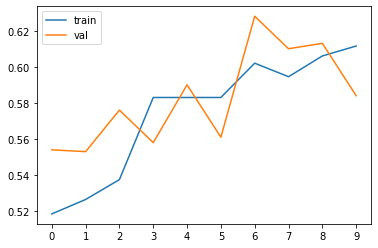

In [8]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [9]:
path = './val/cats'
name = 'cat.10222.jpg'
fullname = f'{path}/{name}'
img = load_img(fullname, target_size=(150, 150))

In [10]:
X = np.array([np.array(img)])
X.shape

(1, 150, 150, 3)

In [11]:
model.predict(X)

array([[0.]], dtype=float32)

# Question 3

What is the median of training accuracy for non-augmented model?



In [12]:
np.median(history.history['accuracy'])

0.5830000042915344

## Question 3 solution

`0.56`

# Quesiton 4

What is the standard deviation of training loss for non-augmented model?

In [13]:
np.std(history.history['loss'])

0.01516039542499041

## Question 4 solution

`0.0116`

# Data augmentation

For the next two questions, we'll generate more data using data augmentations.

Add the following augmentations to your data generator:

* `rotation_range=40,`
* `width_shift_range=0.2,`
* `height_shift_range=0.2,`
* `shear_range=0.2,`
* `zoom_range=0.2,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`

In [14]:
gen_transformed = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )
train_ds = gen_transformed.flow_from_directory(
    './train',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary'
    )
val_ds = gen.flow_from_directory(
    './val',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary'
    )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [15]:
# we don't recreate the model! We keep using the same instance
#model = make_model()
# training
history = model.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_ds,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 21s 209ms/step - loss: 0.6768 - accuracy: 0.5675 - val_loss: 0.6434 - val_accuracy: 0.6400
Epoch 2/10
100/100 [==============================] - 22s 215ms/step - loss: 0.6655 - accuracy: 0.5945 - val_loss: 0.6986 - val_accuracy: 0.5540
Epoch 3/10
100/100 [==============================] - 22s 219ms/step - loss: 0.6706 - accuracy: 0.5825 - val_loss: 0.6567 - val_accuracy: 0.5830
Epoch 4/10
100/100 [==============================] - 22s 220ms/step - loss: 0.6667 - accuracy: 0.5615 - val_loss: 0.6372 - val_accuracy: 0.6270
Epoch 5/10
100/100 [==============================] - 21s 212ms/step - loss: 0.6689 - accuracy: 0.5950 - val_loss: 0.6367 - val_accuracy: 0.6490
Epoch 6/10
100/100 [==============================] - 21s 212ms/step - loss: 0.6558 - accuracy: 0.6210 - val_loss: 0.6693 - val_accuracy: 0.5610
Epoch 7/10
100/100 [==============================] - 22s 218ms/step - loss: 0.6530 - accuracy: 0.5985 - val_loss: 0.6319 - val_ac

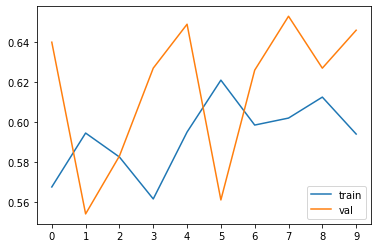

In [16]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

# Question 5

Let's train our model for 10 more epochs using the same code as previously. Make sure you don't re-create the model - we want to continue training the model we already started training.

What is the mean of validation loss for the model trained with augmentations?

In [17]:
np.mean(history.history['val_loss'])

0.6473723590373993

## Question 5 answer

`0.6963`

# Question 6

What's the average of validation accuracy for the last 5 epochs (from 5 to 10) for the model trained with augmentations?

In [18]:
np.average(history.history['val_accuracy'][5:])

0.622599995136261

## Question 6 answer

`0.5076`